In [131]:
from pylab import *
from scipy.ndimage import filters

# Bitwise Encoding

When we modulate a digital signal, we first need to turn it into a string of ones and zeros. This can be a very complicated process in general, using compression, checksums, and error correction.

Here, we just convert text strings into a bit stream.

In [132]:
def encode(s):
    result = zeros(len(s)*8)
    for i in range(len(s)):
        c = ord(s[i])+512 # add a sync bit
        for j in range(8):
            result[i*8+j] = (c&(1<<(7-j))>0)
    return result

def decode(m):
    result = ""
    for i in range(0,len(m)-7,8):
        c = 0
        for j in range(8):
            if m[i+j]: c += (1<<(7-j))
        result += chr(c&0xff)
    return result

Let's try encoding a simple message as a bitstream, and then decoding it again.

The quick brown fox jumped over the lazy dogs.


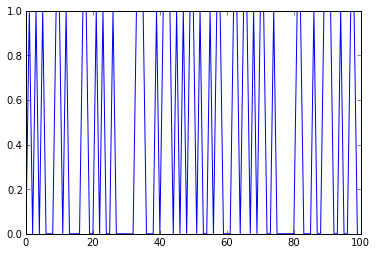

In [133]:
message = encode("The quick brown fox jumped over the lazy dogs.")
print decode(message)
plot(message[:100])

# Signal Generation

An obvious encoding is as a sequence of voltages. However, such an encoding requires precise synchronization for decoding, and if there is a sequence of null characters, such an encoding would likely lose synchronization.

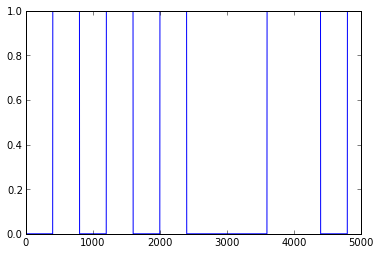

In [134]:
signal = tile(message.reshape(len(message),1),[1,400]).flatten()
plot(signal[:5000])

Here is a better encoding. It uses positive to negative and negative to positive transitions, separated by quiescent inputs.

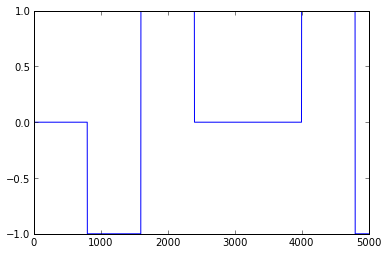

In [135]:
signal = concatenate([[0,1,-1,0] if m else [0,-1,1,0] for m in message])
signal = 1.0*tile(signal.reshape(len(signal),1),[1,800]).flatten()
plot(signal[:5000])

# Signal Decoding

Decoding should usually be resistant to noise

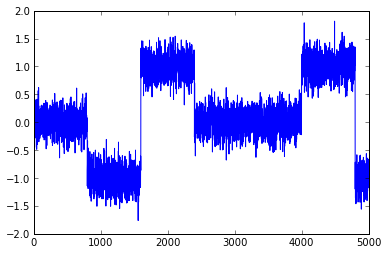

In [136]:
noisy = signal+0.2*randn(len(signal))
plot(noisy[:5000])

How do we carry out the decoding? Remember that the value of each bit is given by the direction of the transition (-1 to 1, 1 to -1). We can find those transitions by taking gradients of the smoothed signal.

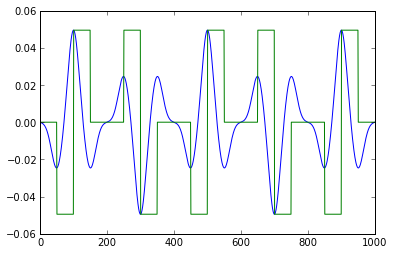

In [137]:
d = 1.0*signal[::16]
d = filters.gaussian_filter(d,16,1)
plot(d[:1000])
plot((amax(d)*signal/amax(signal))[:16000:16])

Now we still need to find the locations of the transitions. We can do this by filtering the absolute signal.

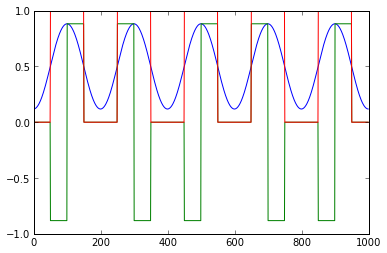

In [138]:
s = abs(1.0*signal[::16])
s = filters.gaussian_filter(s,32.0)
plot(s[:1000])
plot((amax(s)*signal/amax(signal))[:16000:16])
plot(abs(1.0*signal[:16000:16]))

Now we look up the sign at each of the locations of the peaks of the absolute signals.

In [139]:
locations = find(((s>roll(s,-1))*(s>=roll(s,1))))
signs = d[locations]
bits = 1*(signs<0)
print bits

[0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0
 0 0 1 0 1 1 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 1 0 0 0 1 1 0 1 1 0 1 0 1 1 0 0
 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1
 1 0 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1
 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 1 0 1 0 1 0 1 1 0 1 1 0 1 0
 1 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1
 1 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1
 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0
 0 1 1 0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0
 1 0 0 0 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0 0 1 0 1 1 1 0]


Finally, we decode the recovered bits to get back the original text.

In [140]:
print decode(bits)

The quick brown fox jumped over the lazy dogs.


Now let's wrap all of this up in a couple of functions.

The quick brown fox jumped over the lazy dogs.


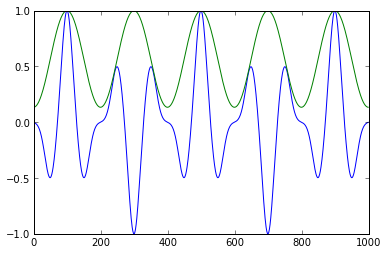

In [141]:
def signal_bits(sig,subsample=16,nplot=0):
    sig = 1.0*sig[::subsample]
    d = filters.gaussian_filter(sig,16.0,1)
    if nplot>0: plot(d[:nplot]/amax(d))
    s = abs(1.0*sig)
    s = filters.gaussian_filter(s,32.0)
    if nplot>0: plot(s[:nplot]/amax(s))
    l = find(((s>roll(s,-1))*(s>=roll(s,1))*(s>amax(s)*0.5)))
    signs = d[l]
    return signs

def signal_decode(sig,subsample=16,nplot=0):
    signs = signal_bits(sig,subsample=subsample,nplot=nplot)
    bits = 1*(signs<0)
    return decode(bits)

print signal_decode(signal,nplot=1000)

# Frequency Modulation

Now we're going to perform frequency modulation.

Note that we change the instantaneous frequency, but accumulate the phase over time. If we just change the frequency discontinously, we'd get jumps in the output.

In [142]:
def modulate(f,b,signal):
    "Frequency modulation."
    fs = f+signal*b
    phis = add.accumulate(2*pi*fs)
    signal = sin(phis)
    return signal

Now let's create a modulated signal.

In [143]:
freq = 0.1
b = 0.02
modulated = modulate(freq,b,signal)

Let's add some amplitude modulation as well, mostly to show that frequency modulation is robust to such disturbances.

In [144]:
am = filters.gaussian_filter(randn(len(modulated)),10.0)
am /= amax(am)
modulated *= 1.0+0.3*am

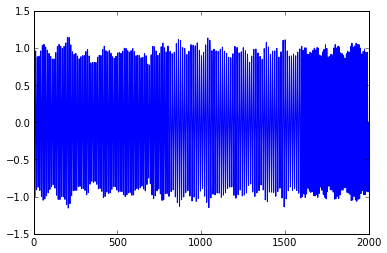

In [145]:
plot(modulated[:2000])

# Decoding with Windowed Fourier Transform

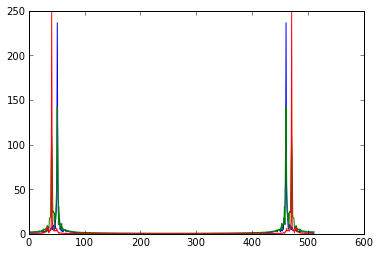

In [146]:
plot(abs(fft(modulated[0:512])))
plot(abs(fft(modulated[512:1024])))
plot(abs(fft(modulated[1024:1536])))

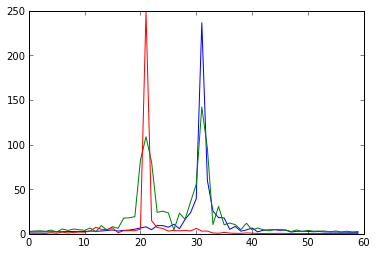

In [147]:
plot(abs(fft(modulated[0:512]))[20:80])
plot(abs(fft(modulated[512:1024]))[20:80])
plot(abs(fft(modulated[1024:1536]))[20:80])

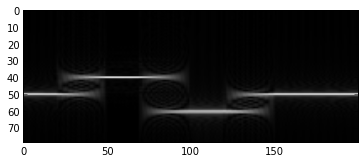

In [148]:
ws = 512
step = 16
result = []
for i in range(0,len(modulated)-ws,step):
    ft = abs(fft(modulated[i:i+ws]))
    result.append(ft)
result = array(result)
imshow(result[:200,1:80].T)

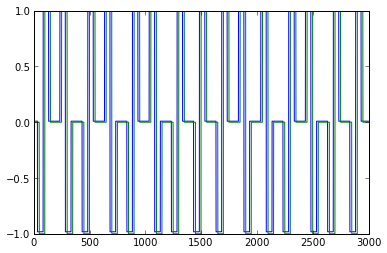

In [149]:
fsignal = argmax(result[:,3:result.shape[1]/2],axis=1)
fsignal = fsignal-mean(fsignal)             
plot(fsignal[:3000]/amax(fsignal))
plot(signal[:48000:16])

The quick brown fox jumped over the lazy dogs.


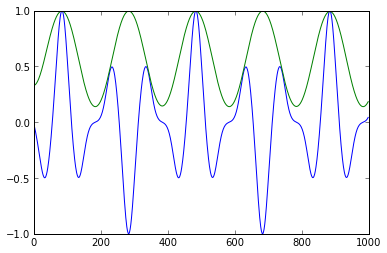

In [150]:
print signal_decode(fsignal,subsample=1,nplot=1000)

In [151]:
def fft_fm_demodulate(modulated,nplot=0,lo=1,hi=80):
    ws = 512
    step = 16
    result = []
    for i in range(0,len(modulated)-ws,step):
        ft = abs(fft(modulated[i:i+ws]))
        result.append(ft)
    result = array(result)
    if nplot>0: imshow(result[:nplot,lo:hi].T)
    fsignal = argmax(result[:,lo:min(hi,result.shape[1]/2)],axis=1)
    fsignal = fsignal-mean(fsignal)
    return fsignal

'The quick brown fox jumped over the lazy dogs.'

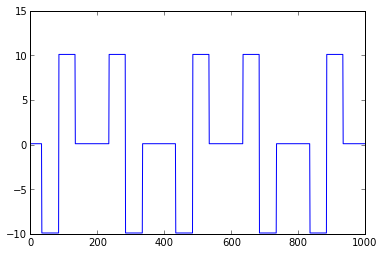

In [152]:
fsignal = fft_fm_demodulate(modulated)
plot(fsignal[:1000])
signal_decode(fsignal,subsample=1)

# Decoding with Quadrature

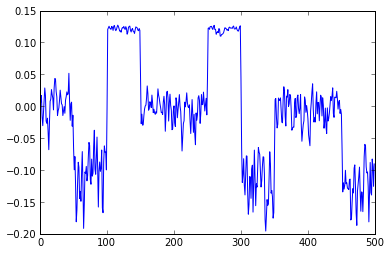

In [153]:
shift = 2
decoded = modulated*roll(modulated,shift)
decoded = filters.gaussian_filter(decoded,5.0)
decoded -= mean(decoded)
plot(-decoded[:8000:16])

In [154]:
print signal_decode(-decoded)

The quick brown fox jumped over the lazy dogs.


# Image Steganography

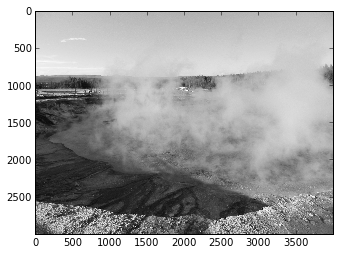

In [162]:
image = 1.0*mean(imread("geyser.jpg"),axis=2)
image /= amax(image)
gray()
imshow(image)

In [163]:
print image.size,len(modulated)

12000000 1177600


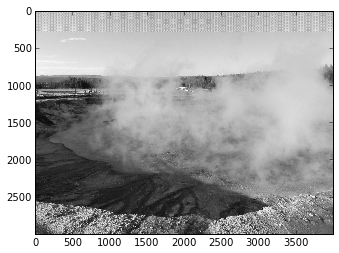

In [164]:
stega = 0.0+image.ravel()
stega[:len(modulated)] += 0.1*modulated[:len(stega)]
stega.shape = image.shape
imshow(stega)

The quick brown fox jumped over the lazy dogs.


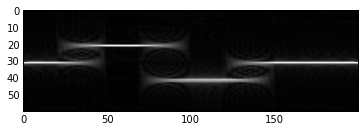

In [158]:
fsignal = fft_fm_demodulate(stega.ravel()[:len(modulated)],nplot=200,lo=20)
print signal_decode(fsignal,subsample=1)

In [ ]:
imsave("stega.jpg",stega)
stega2 = imread("stega.jpg")
imshow(stega2)
fsignal = fft_fm_demodulate(stega2.ravel()[:len(modulated)],lo=20)
print signal_decode(fsignal,subsample=1)

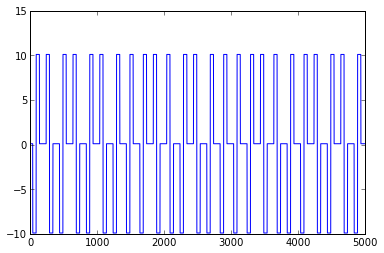

In [159]:
plot(fsignal[:5000])

In [160]:
def roundtrip(l=0.01):
    stega = 0.0+image.ravel()
    stega[:len(modulated)] += l*modulated
    fsignal = fft_fm_demodulate(stega[:len(modulated)])
    return signal_decode(fsignal,subsample=1)

for l in exp(linspace(log(0.5),log(0.001),20)):
    print "%.4f"%l,roundtrip(l)

0.5000 The quick brown fox jumped over the lazy dogs.
0.3605 The quick brown fox jumped over the lazy dogs.
0.2599 The quick brown fox jumped over the lazy dogs.
0.1874 The quick brown fox jumped over the lazy dogs.
0.1351 The quick brown fox jumped over the lazy dogs.
0.0974 The quick brown fox jumped over the lazy dogs.
0.0703 The quick brown fox jumped over the lazy dogs.
0.0507 The quick brown fox jumped over the lazy dogs.
0.0365 �as5�cJb0�k^n fkX"jumped over the lazy dogs.
0.0263 �as5�cJb0�k^f0�kXb8�iXg4�k^g0�qHg0�aZs0�kNs<
0.0190 "w3#ffb#s'3
��dVYl��l�Il�Y,��,

0.0137 "vFfb"c$v�T*c&�%w
C4"
� q'3� �

0.0099 �ږ4ʍD�������-v-�,�)�3�v��e����(�U��-�m���Z
0.0071 ���y��y����п�5���΂���c�X{��m�/�e�?�m�[m���g�Lo��%
0.0051 �|�*��>LP㮘WawȞ�䧌��yzh�
�����h鶦��

0.0037 ;�����aD���h<,	�+xo[���|.��k�
0.0027 ��v�`P	�aB�7oO��.��
0.0019 �P
f���

0.0014 �A
���
0.0010 � n<
